In [1]:
import numpy as np
import pandas as pd # only used to read the MNIST data set
import networkx as nx
from datetime import datetime
import sklearn.tree
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import random
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm
import os
os.path.abspath(os.getcwd())

class Reservoir:
    def __init__(self,
                 graph,
                 spectral_radius = 0.9,
                 sparsity = None,
                 pca_reduce = False,
                 prediction_model = MLPRegressor,
                 prediction_model_kwargs = {"verbose":True, "hidden_layer_sizes":(20,)}):

        self.adjacency = graph
        self.prediction_model = prediction_model(**prediction_model_kwargs)
        # Wu should be initialised when .fit is called
        self.Wx = self.create_weights(spectral_radius=spectral_radius,
                                      sparsity=sparsity)
        self.Wu = None
        self.pca_reduce = pca_reduce

        if self.pca_reduce:
            self.pca = PCA(n_components=10)



    def create_weights(self, low=-1.0, high=1.0, sparsity=None, spectral_radius=None):
        shape = tuple(self.adjacency.shape)
        w = (high - low) * np.random.ranf(shape[0] * shape[1]).reshape(shape) + low  # create the weight matrix
        w[self.adjacency == 0] = 0.
        if not sparsity is None:  # if sparsity is defined
            s = np.random.ranf(shape[0] * shape[1]).reshape(shape) < (1.0 - sparsity)  # create a sparse boolean matrix
            w *= s  # set weight matrix values to 0.0
        if not spectral_radius is None:  # if spectral radius is defined
            sp = np.max(np.abs(np.linalg.eig(w)[0]))  # compute current spectral radius
            w *= (spectral_radius) / sp  # adjust weight matrix to acheive specified spectral radius
        return w


    def vis_graph(self, weights = None, name = "Reservoir_Graph", node_colours = None):
        if weights is not None:
            G = nx.from_numpy_matrix(np.matrix(weights), create_using=nx.Graph)
        else:
            G = nx.from_numpy_matrix(np.matrix(self.adjacency), create_using=nx.Graph)

        node_colours = node_colours if node_colours is not None else np.ones(G.order())

        print(f"Calculating positions for {G}")
        pos = nx.nx_pydot.graphviz_layout(G, prog = "sfdp")

        fig, ax = plt.subplots(figsize=(9,9))
        nx.draw_networkx_nodes(G, pos = pos,
                               node_size=100*node_colours,
                               node_color=node_colours)
        if weights is not None:
            weights = np.array([G[u][v]['weight'] for u, v in G.edges()])
            print(f"Drawing edges")
            nx.draw_networkx_edges(G, pos = pos, width=weights, alpha = np.abs(weights), ax = ax)
        else:
            nx.draw_networkx_edges(G, pos = pos, alpha=0.1, width = 0.1, ax = ax)

        plt.savefig(f"{name}.png", dpi=600)
        # plt.show()

    def fit(self, series, targets):
        self.Wu = 0.25*np.ones([self.Wx.shape[0], series.shape[0]])

        # Essentially training data, currently no warm-up
        embedded_states = self.forward(series)
        if self.pca_reduce:
            pca_embedded = self.pca.fit_transform(embedded_states)
        else:
            pca_embedded = embedded_states
        # print(embedded_states)
#         print(len(series), len(targets))
        self.prediction_model.fit(pca_embedded, targets)
        # plot_tree(self.prediction_model)
        # plt.show()


    def predict(self, series):
        assert self.Wu is not None, "Input weight matrix doesn't exist, must call .fit before .predict"
        embedded_states = self.forward(series)
        if self.pca_reduce:
            pca_embedded = self.pca.transform(embedded_states)
        else:
            pca_embedded = embedded_states
        prediction = self.prediction_model.predict(pca_embedded)

        return prediction, embedded_states


    # Alex's function for a simple reservoir operation - please sense check!
    def forward(self, input, remove_node_idxs=[]):
        # Input should be shape |V| x n_steps
        n_steps = input.shape[1]
        x_size = self.Wx.shape[0] # Network size

        assert self.Wu is not None, f"Wu has not been initialised, please call .fit"

        u_size = self.Wu.shape[1] # Input vector size
        x = np.zeros((x_size, 1))
        states = []
        for step in (range(n_steps)):
            # print(input.shape, u_size, self.Wu.shape)
            step_data = input[:, step].reshape((u_size, 1))

            # print(self.Wu.shape)
            # print(step_data)
            # print(np.vstack((1, step_data)))

            u = np.dot(self.Wu, step_data)
            # u = np.dot(self.Wu, np.vstack((1, step_data)))
            u[remove_node_idxs] = 0.

            x = np.tanh(u + np.dot((self.Wx+np.identity(x_size)), x))
            states += [x.flatten()]

            # if step == 0:
            #     x_state = (x)
            # else:
            #     x_state = np.hstack((x_state, x))
        return states
def getData(steps, T, n_in_train, t0 = 0, noise_val = 0.025):
    # Time domain
    ts = np.linspace(t0,T, num=steps)

    t_noise = np.random.randn(steps)
    # Add more noise in non-train section
    t_noise *= noise_val

    # Data generating functions
    frequencies = np.cos(ts)
    amp_saved = np.sin(np.pi*frequencies) + t_noise
    # Shape stuff
    amplitudes = np.copy(amp_saved).reshape((1, -1))
    amplitudes = np.concatenate((amplitudes, amplitudes), axis=0)

    # test data is all the data to ensure network is contains the latent state initialising unseen states
    frequencies_test = frequencies
    frequencies_train = frequencies[:n_in_train]

    amplitudes_test = amplitudes
    amplitudes_train = amplitudes[:,:n_in_train]

    amp_saved_test = amp_saved
    amp_saved_train      = amp_saved[:n_in_train]
    
    return amplitudes_train, amplitudes_test, frequencies_train, frequencies_test

In [2]:
fly_mat = pd.read_csv('science.add9330_data_s1_to_s4/Supplementary-Data-S1/all-all_connectivity_matrix.csv').drop(columns=['Unnamed: 0'])
fly_mat = fly_mat.to_numpy()
# Convert fly matrix into binary adjacency matrix
fly_mat[fly_mat > 0] = 1
fly_mat[fly_mat != 1] = 0
fly_mat[np.identity(fly_mat.shape[0], dtype=bool)] = 0.
fly_graph = fly_mat
print('fly density: ', np.sum(fly_mat.reshape(-1))/(fly_mat.shape[0]*fly_mat.shape[1]))

fly density:  0.012638989872283547


In [3]:
rand_graph = nx.fast_gnp_random_graph(fly_graph.shape[0], np.sum(fly_graph) / (fly_graph.shape[0] ** 2))
rand_graph = nx.to_numpy_array(rand_graph)

rand_graph[np.identity(rand_graph.shape[0], dtype=bool)] = 0.

print(f"Fly graph {np.sum(fly_graph)} edges, rand graph {np.sum(rand_graph)} edges")

Fly graph 110140.0 edges, rand graph 109680.0 edges


In [4]:
# initilise learning algorithm, this can be changed later
model = RandomForestRegressor
model_kwargs = {"n_estimators":100, "verbose":0, "n_jobs":6, "max_depth":5}
model_name = str(model).split('.')[-1].split("'")[0]
# Initialise reservoirs
fly_res = Reservoir(fly_graph, prediction_model=model, prediction_model_kwargs=model_kwargs)
rand_res = Reservoir(rand_graph, prediction_model=model, prediction_model_kwargs=model_kwargs)

In [5]:
# define learning algorithm
model = RandomForestRegressor
model_kwargs = {"n_estimators":100, "verbose":0, "n_jobs":6, "max_depth":5}
model_name = str(model).split('.')[-1].split("'")[0]

In [ ]:
REPS = 10
SAMPLESIZES = np.arange(10, 5000, 100)
NOISES = np.linspace(0.01, 1, 10)


# data params
n_in_train, n_test, noise = 100, 100, 0.025

LC_fly_tr, LC_fly_te = [],[]
LC_ran_tr, LC_ran_te = [],[]
LC_def_tr, LC_def_te = [],[]

for n_in_train in tqdm(SAMPLESIZES):
# for noise in tqdm(NOISES):
#     n_in_train = 100
    total = n_in_train + n_test

    fly_err_i_tr, fly_err_i_te = [], []
    ran_err_i_tr, ran_err_i_te = [], []
    def_err_i_tr, def_err_i_te = [], []

    for rep in range(REPS):
        amplitudes_train, amplitudes_test, frequencies_train, frequencies_test = getData(total, 8*np.pi, 
                                                                                         n_in_train, noise_val=noise)
        fly_res.prediction_model, rand_res.prediction_mode = model(), model()
        fly_res.prediction_model_kwargs, rand_res.prediction_model_kwargs = model_kwargs, model_kwargs
        # fit learning components
        fly_res.fit(amplitudes_train, frequencies_train)
        rand_res.fit(amplitudes_train, frequencies_train)
        default_regressor = model(**model_kwargs).fit(amplitudes_train.transpose(), frequencies_train)
        # predict
        fly_prediction, fly_states = fly_res.predict(amplitudes_test)
        rand_prediction, rand_states = rand_res.predict(amplitudes_test)
        default_predicted = default_regressor.predict(amplitudes_test.transpose())
        # evaluate train
        fly_train_performance = mean_squared_error(fly_prediction[:n_in_train], frequencies_test[:n_in_train])
        rand_train_performance = mean_squared_error(rand_prediction[:n_in_train], frequencies_test[:n_in_train])
        default_train_performance = mean_squared_error(default_predicted[:n_in_train], frequencies_test[:n_in_train])
        # evaluate test
        fly_test_performance = mean_squared_error(fly_prediction[n_in_train:], frequencies_test[n_in_train:])
        rand_test_performance = mean_squared_error(rand_prediction[n_in_train:], frequencies_test[n_in_train:])
        default_test_performance = mean_squared_error(default_predicted[n_in_train:], frequencies_test[n_in_train:])

        fly_err_i_tr.append(fly_train_performance)
        fly_err_i_te.append(fly_test_performance)
        ran_err_i_tr.append(rand_train_performance)
        ran_err_i_te.append(rand_test_performance)
        def_err_i_tr.append(default_train_performance)
        def_err_i_te.append(default_test_performance)

    stat = np.mean    
    LC_fly_tr.append(stat(fly_err_i_tr))
    LC_fly_te.append(stat(fly_err_i_te))
    LC_ran_tr.append(stat(ran_err_i_tr))
    LC_ran_te.append(stat(ran_err_i_te))
    LC_def_tr.append(stat(def_err_i_tr))
    LC_def_te.append(stat(def_err_i_te))

  0%|              | 0/50 [00:00<?, ?it/s]

Text(0, 0.5, 'MSE')

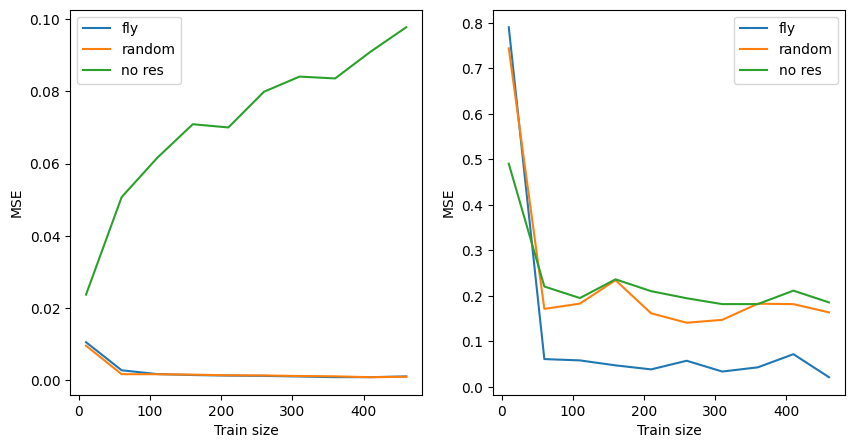

In [10]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

ax[0].plot(SAMPLESIZES,LC_fly_tr, label = 'fly')
ax[0].plot(SAMPLESIZES,LC_ran_tr, label = 'random')
ax[0].plot(SAMPLESIZES,LC_def_tr, label = 'no res')

ax[1].plot(SAMPLESIZES,LC_fly_te, label = 'fly')
ax[1].plot(SAMPLESIZES,LC_ran_te, label = 'random')
ax[1].plot(SAMPLESIZES,LC_def_te, label = 'no res')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Train size')
ax[1].set_xlabel('Train size')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('MSE')

Text(0, 0.5, 'MSE')

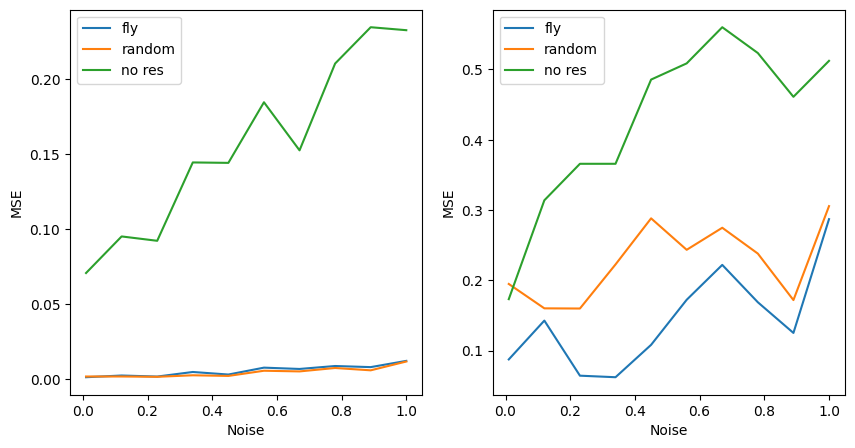

In [19]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

ax[0].plot(NOISES,LC_fly_tr, label = 'fly')
ax[0].plot(NOISES,LC_ran_tr, label = 'random')
ax[0].plot(NOISES,LC_def_tr, label = 'no res')

ax[1].plot(NOISES,LC_fly_te, label = 'fly')
ax[1].plot(NOISES,LC_ran_te, label = 'random')
ax[1].plot(NOISES,LC_def_te, label = 'no res')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Noise')
ax[1].set_xlabel('Noise')
ax[0].set_ylabel('MSE')
ax[1].set_ylabel('MSE')